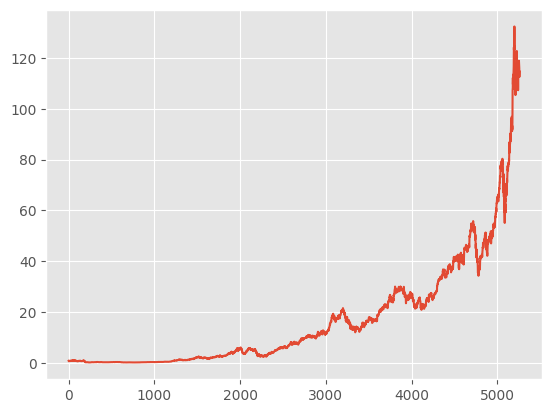

In [45]:
import bs4 as bs
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import os
import pandas as pd 
import pickle
import requests
import yfinance as yf

style.use('ggplot')

def save_sp500_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'html.parser')
    table = soup.find('table', {'class':'wikitable sortable'})
    tickers = [row.find('td').text.strip().replace('.', '-') for row in table.find_all('tr')[1:]]
    
    with open('sp500tickers.pickle', 'wb') as f:
        pickle.dump(tickers, f)
    return tickers

def get_data_from_yahoo(reload_sp500=False):
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open('sp500tickers.pickle', 'rb') as f:
            tickers = pickle.load(f)
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')
    
    start = dt.datetime(2000, 1, 1)
    end = dt.datetime(2020, 11, 26)

    for ticker in tickers:
        if not os.path.exists(f'stock_dfs/{ticker}.csv'):
            df = yf.download(ticker, start, end)
            df.reset_index(inplace=True)
            df.set_index('Date', inplace=True)
            df.to_csv(f'stock_dfs/{ticker}.csv')
        else:
            print(f'Already have {ticker}')

def compile_data():
    with open("sp500tickers.pickle","rb") as f:
        tickers = pickle.load(f)
        
    main_df = pd.DataFrame()
    
    for count, ticker in enumerate(tickers):
        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
        df.set_index('Date', inplace=True)
        
        df.rename(columns ={'Adj Close': ticker}, inplace=True)
        df.drop(['Open','High','Low','Close','Volume'],1,inplace=True )
        
        if main_df.empty:
            main_df = df
        else:
            main_df = main_df.join(df, how='outer')
            
        if count % 10 == 0:
            print(count)
            
    print(main_df.head())
    main_df.to_csv('sp500_joined_closes.csv')
    
def visualize_data():
    df = pd.read_csv('sp500_joined_closes.csv')
    df['AAPL'].plot()
    plt.show()
    
visualize_data()
